In [1]:
import nltk
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
# Extracting sentences and tag set and word list
tagged_sent=nltk.corpus.brown.tagged_sents(tagset='universal')
print(tagged_sent[0])
l1 = list([])
l = [l1.extend(list(zip(*i))[1]) for i in tagged_sent]
setOfTags = list(set(l1))
setOfTags.append('START')
# setOfTags.append('END')
print(setOfTags)
l2 = list([])
l = [l2.extend(map(lambda x:x.lower(),list(zip(*i))[0])) for i in tagged_sent]
V = len(l2)
setOfWords = list(set(l2))
setOfWords.append('^')
noOfSentences = len(tagged_sent)

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]
['PRT', 'ADP', 'VERB', 'ADV', 'DET', '.', 'PRON', 'ADJ', 'X', 'NUM', 'CONJ', 'NOUN', 'START']


In [6]:
from collections import Counter
# Emmision probabilities
countEmit = dict(zip(setOfTags,[dict(zip(setOfWords,[1/V]*len(setOfWords))) for i in range(len(setOfTags))]))
for sent in trainSent:
  countEmit['START']['^'] += 1
  for word in sent:
    countEmit[word[1]][word[0].lower()] += 1
countEmit = {k1:{k2:float(v2)/countTags[k1]  for k2,v2 in v.items()} for k1,v in countEmit.items()}
k = Counter(countEmit['.'])
high = list(zip(*k.most_common(14)))[0]
print(high)
# countEmit

(',', '.', '``', "''", ';', '?', '--', ')', '(', ':', '!', "'", '[', ']')


In [3]:
# Viterbi algorithm
boostingFactor = 1e20
boostingCycle = 5
alpha = 1e-5
high = [',', '.', '``', "''", ';', '?', '--', ')', '(', ':', '!', "'", '[', ']']
def viterbi(sent):
  T = len(sent) + 1
  N = len(setOfTags)
  v = dict(zip([i for i in range(T)],[dict(zip(setOfTags,[0]*len(setOfTags))) for i in range(T)]))
  backtrace = dict(zip([i for i in range(T)],[dict(zip(setOfTags,[0]*len(setOfTags))) for i in range(T)]))
  v[0]['START'] = 1
  for t in range(1,T):
    for tag in setOfTags:
      maxValue = 0
      maxTag = 'START'
      for i in setOfTags:
        if maxValue < v[t-1][i]*countTrans[i][tag]*countEmit[tag][sent[t-1].lower()]:
          maxValue = v[t-1][i]*countTrans[i][tag]*countEmit[tag][sent[t-1].lower()]
          maxTag = i
      if t%boostingCycle == 0:
        v[t][tag] = maxValue*boostingFactor
      else:
        v[t][tag] = maxValue
      backtrace[t][tag] = maxTag
  maxLast = 0
  lastTag = '.'
  for tag in setOfTags:
    if maxLast < v[T-1][tag]:
      lastTag = tag
  originalSequence = list(['.'])
  time = T-1
  currTag = lastTag
  currTag = '.'
  while time>0:
    currTag = backtrace[time][currTag]
    if time>1 and sent[time-2] in high:
      originalSequence.insert(0,'.')
      currTag = '.'
      # if currTag == 'ADJ':
      #   print(sent,time)
      # print(sent[time-2],currTag)
    else:
      originalSequence.insert(0,currTag)
    time -= 1
  return originalSequence

# viterbi(list(list(zip(*testSent[1]))[0]))
# testSent[1]

In [4]:
# With Cross validation

import numpy as np
from sklearn.model_selection import KFold 
kf = KFold(n_splits=5)
noOfSentences = len(tagged_sent)
finalAcc = 0
fold = 0
tagged_sent = np.array(tagged_sent)
alpha = 0 # smoothing parameter
confusionMatrix = dict(zip(setOfTags,[dict(zip(setOfTags,[0]*len(setOfTags))) for i in range(len(setOfTags))]))
for trainIndex,testIndex in kf.split(tagged_sent):
  # print(trainIndex)
  trainSent = tagged_sent[trainIndex]
  testSent = tagged_sent[testIndex]
  print("Training for {} fold".format(fold))
  # testSent = tagged_sent[fold*int(noOfSentences*0.2):(fold+1)*int(noOfSentences*0.2)]
  # print(testSent)
  # trainSent = tagged_sent[fold*int(noOfSentences*0.2):max(noOfSentences,fold*int(noOfSentences*0.2) +int(noOfSentences*0.8))]
  
  # trainSent = list(set(tagged_sent)-set(testSent))
  countTags = dict(zip(setOfTags,[0]*len(setOfTags)))
  countTrans = dict(zip(setOfTags,[dict(zip(setOfTags,[0]*len(setOfTags))) for i in range(len(setOfTags))]))
  count = 0
  # print(trainSent[0])
  for sent in trainSent:
    countTags['START'] += 1
    prevState = 'START'
    for word in sent:
      countTrans[prevState][word[1]] += 1
      # print('increased {} {} by 1'.format(prevState,word[1]))
      # print(countTrans)
      countTags[word[1]] += 1
      prevState = word[1]
  countTrans = {k1:{k2:float(v2)/countTags[k1]  for k2,v2 in v.items()} for k1,v in countTrans.items()}
  countEmit = dict(zip(setOfTags,[dict(zip(setOfWords,[1/V]*len(setOfWords))) for i in range(len(setOfTags))]))
  for sent in trainSent:
    countEmit['START']['^'] += 1
    for word in sent:
      countEmit[word[1]][word[0].lower()] += 1
  countEmit = {k1:{k2:float(v2+alpha)/(countTags[k1]+alpha*V)  for k2,v2 in v.items()} for k1,v in countEmit.items()}
  correct = 0
  total = 0
  for sent in testSent:
    pred = viterbi(list(list(zip(*sent))[0]))
    trueSent = list(list(zip(*sent))[1])
    trueSent.insert(0,'START')
    correct += sum(map(lambda i,j:i==j,pred,trueSent))
    total += len(trueSent)
    count = 0
    for predictedTag,tag in zip(pred,trueSent):
      # if predictedTag == 'ADJ' and tag == '.' :
        # print(sent,count)
      confusionMatrix[tag][predictedTag] += 1
      count+=1
  finalAcc += correct/total
  print("Accuracy on the test set for fold {} is {}".format(fold,correct/total))
  fold+=1
print("Average Accuracy on the 5 folds is {}".format(finalAcc/5))

Training for 0 fold
Accuracy on the test set for fold 0 is 0.9363780802664344
Training for 1 fold
Accuracy on the test set for fold 1 is 0.9416085848506248
Training for 2 fold
Accuracy on the test set for fold 2 is 0.9447594902928814
Training for 3 fold
Accuracy on the test set for fold 3 is 0.9472491034912318
Training for 4 fold
Accuracy on the test set for fold 4 is 0.9443511869605313
Average Accuracy on the 5 folds is 0.9428692891723408


In [5]:
# Code for beautifying confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    plt.savefig('confM')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


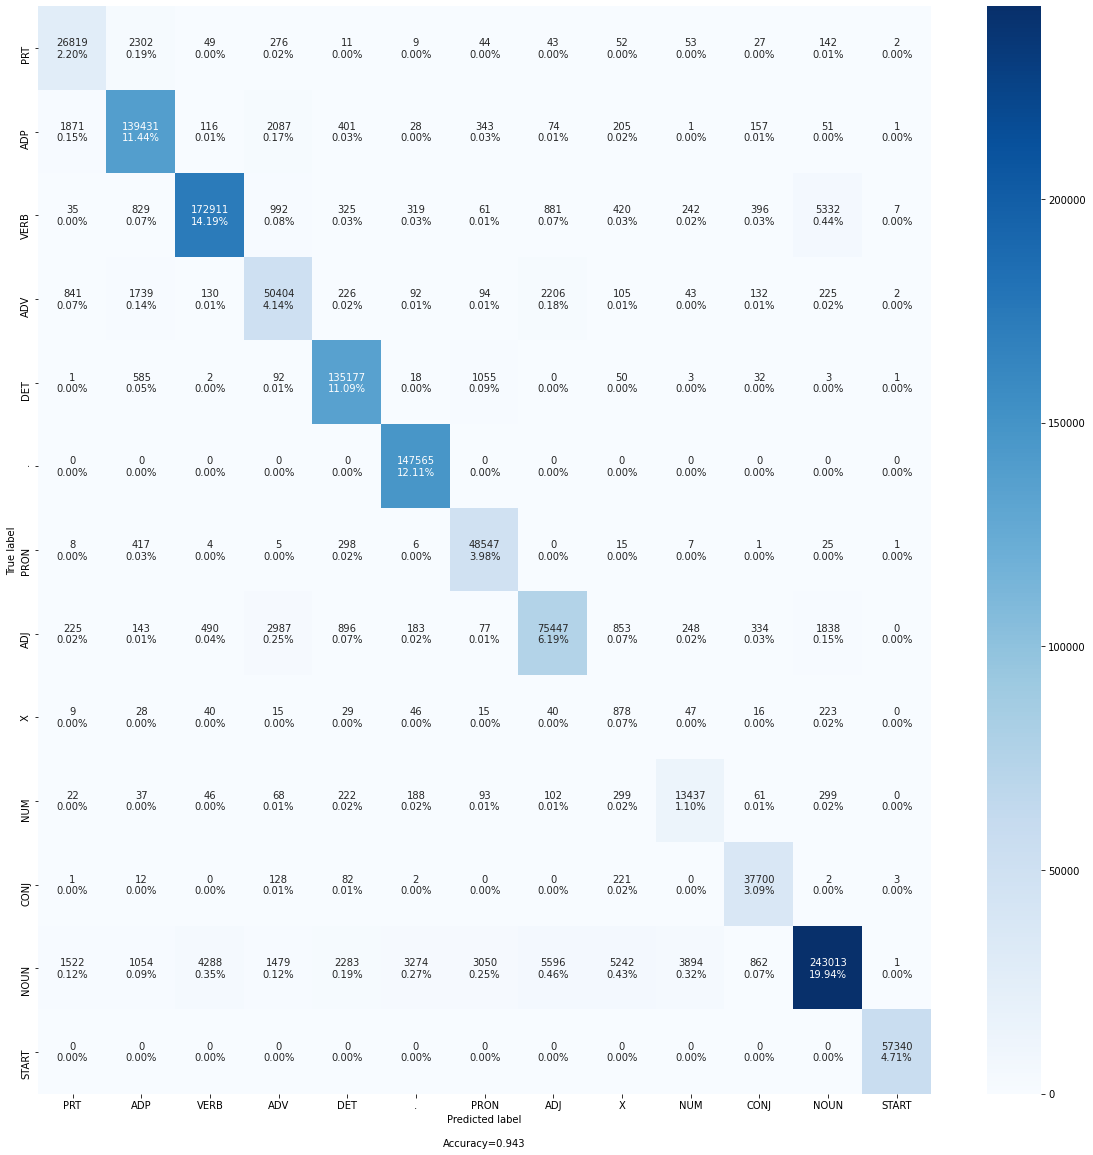

In [6]:
# Prints the confusion matrix
import seaborn as sns
sot = len(setOfTags)
cm = [[0]*sot for i in range(sot)]
for i in range(sot):
  for j in range(sot):
    cm[i][j] = confusionMatrix[setOfTags[i]][setOfTags[j]]

cm = np.array(cm)
categories = setOfTags
make_confusion_matrix(cm,figsize=(20,20),categories=categories)

In [ ]:
from collections import Counter
confusionMatrix['.']['ADJ']
k = Counter(countEmit['.'])
high = list(zip(*k.most_common(14)))[0]
print(high)

(',', '.', '``', "''", ';', '?', '--', ')', '(', ':', '!', "'", ']', '[')


In [ ]:
cm.diagonal()/cm.sum(axis=1)

array([0.88189419, 0.89909149, 0.98404751, 0.63347763, 1.        ,
       0.90117175, 0.94616142, 0.90338846, 0.89624638, 0.96314742,
       0.98655661, 0.98817855, 1.        ])

In [ ]:
setOfTags

['NOUN',
 'PRT',
 'PRON',
 'X',
 '.',
 'ADJ',
 'VERB',
 'NUM',
 'ADV',
 'ADP',
 'DET',
 'CONJ',
 'START']